In [1]:
# this mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# FOLDERNAME = 'Anomaly/data/NAB'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [3]:
import torch
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision.transforms as T

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets
from torchvision.utils import save_image
from torch.utils.data import sampler
import matplotlib.pyplot as plt

import numpy as np
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [14]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():

    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [4]:
# %cd /content/drive/My\ Drive/Anomaly/data/NAB

/content/drive/My Drive/Anomaly/data/NAB


In [15]:
# Plot data
%matplotlib inline

import warnings
import itertools
import pandas
import math
import sys
import os
import numpy as np
from plotly.offline import download_plotlyjs, plot, iplot
# import plotly.io as pio
# pio.renderers.default = 'colab'

# data_file_list = ["./data/realTweets/Twitter_volume_AAPL.csv",
#              "./data/realTweets/Twitter_volume_AMZN.csv",
#              "./data/realTweets/Twitter_volume_CRM.csv",
#              "./data/realTweets/Twitter_volume_CVS.csv",
#              "./data/realTweets/Twitter_volume_FB.csv",
#              "./data/realTweets/Twitter_volume_GOOG.csv",
#              "./data/realTweets/Twitter_volume_IBM.csv",
#              "./data/realTweets/Twitter_volume_KO.csv",
#              "./data/realTweets/Twitter_volume_PFE.csv",
#              "./data/realTweets/Twitter_volume_UPS.csv"]

data_file_list = ["../data/NAB/data/realAdExchange/exchange-2_cpc_results.csv",
                  "../data/NAB/data/realAdExchange/exchange-2_cpm_results.csv"]

for data_file in data_file_list:
  Error = None
  if os.path.isfile(data_file):
      dataframe = pandas.read_csv(data_file)
  else:
      Error = "No such file : "+data_file
      print(Error)
  if set(['timestamp','value']).issubset(dataframe.columns) and Error is None:
      x = np.array(dataframe['timestamp'])
      print('Number of samples: ', x.shape[0])
      y = np.array(dataframe['value'])
      mean = np.mean(y)

      trace = {"x": x,
              "y": y,
              "mode": 'lines',
              "name": 'Value'}
      trace_mean = {"x": x,
                    "y": np.ones(len(x))*mean,
                    "mode": 'lines',
                    "name": 'Mean'}
      traces = [trace,trace_mean]
      layout = dict(title = "Data plot : "+data_file,
                    xaxis = dict(title = 'X'),
                    yaxis = dict(title = 'Value')
                  )
      fig = dict(data=traces, layout=layout)
      iplot(fig)
      
  else:
      if Error is None:
          Error = "Missing colomns in file "+data_file
      print(Error)

Number of samples:  1624


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [6]:
# Fallen layer hidden variable
class Flatten(nn.Module):
  def forward(self, x):
    N = x.shape[0]
    return x.view(N, -1)

class Flatten_inverse(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape
  def forward(self, x):
    return x.view(self.shape)

In [7]:
# Residual Block for Encoder and Decoder
class ResidualBasicBlock(nn.Module):
  def __init__(self, 
               in_channels, 
               out_channels, 
               downsampling=False,
               upsampling=False):
    
    super().__init__()
    self.in_channels, self.out_channels = in_channels, out_channels
    self.upsampling, self.downsampling = upsampling, downsampling
    if self.downsampling:
      conv1 = nn.Conv1d(in_channels, 
                        int(out_channels / 2), 
                        kernel_size=3,
                        stride=2,
                        padding=1
      )
    elif self.upsampling:
      conv1 = nn.ConvTranspose1d(in_channels,
                                int(out_channels/2),
                                kernel_size=2,
                                stride=2,
                                padding=0 
      )
    else:
      conv1 = nn.Conv1d(in_channels, 
                        int(out_channels / 2), 
                        kernel_size=3,
                        stride=1,
                        padding=1
      )
      
    conv2 = nn.Conv1d(
        int(out_channels/2),
        out_channels,
        kernel_size=3,
        stride=1,
        padding=1
    )


    self.blocks = nn.Sequential(
      conv1,
      # nn.BatchNorm1d(int(out_channels/2)),
      nn.LeakyReLU(),
      conv2,
      # nn.BatchNorm1d(out_channels),
      nn.LeakyReLU()
    )
    if self.downsampling == True:
      self.shortcut = nn.Sequential(
          nn.Conv1d(self.in_channels, 
                    self.out_channels, 
                    kernel_size=1,
                    stride= 2, 
                    padding=0
                    )
          # nn.BatchNorm1d(self.out_channels)
      )    
    elif self.upsampling == True:
      self.shortcut = nn.Sequential(
          nn.ConvTranspose1d(self.in_channels, 
                              self.out_channels, 
                              kernel_size=1,
                              stride= 2,
                              output_padding=1,
                    )
          # nn.BatchNorm1d(self.out_channels)
      )
    else:
      self.shortcut = nn.Sequential(
          nn.Conv1d(self.in_channels, 
                    self.out_channels, 
                    kernel_size=1,
                    stride= 1, 
                    padding=0
                    )
          # nn.BatchNorm1d(self.out_channels)
      )   

  def forward(self, x):
    residual = self.shortcut(x)
    x = self.blocks(x)
    x += residual
    return x

In [8]:
# Test forward path of a single Residual Block
N = 10
C = 2
L = 32
model = ResidualBasicBlock(2, 5)
model.eval()
print(model(torch.rand((N, C, L))).shape)

torch.Size([10, 5, 32])


In [9]:
# Encoder
class Encoder(nn.Module):
  def __init__(self, in_channels, hidden_channels, downsampling, hidden_var, L, N):
    super().__init__()
    self.in_channels, self.hidden_channels = in_channels, hidden_channels
    self.downsampling, self.hidden_var = downsampling, hidden_var
    self.L = L
    for b in self.downsampling:
      if b:
        self.L = int(self.L / 2)

    self.gate = nn.Sequential(
        nn.Conv1d(
            self.in_channels,
            self.hidden_channels[0],
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        # nn.BatchNorm1d(self.hidden_channels[0])
    )
    self.blocks = nn.ModuleList(
        [
         *[ResidualBasicBlock(hidden_channels[i], 
                            hidden_channels[i+1],
                            downsampling=self.downsampling[i])
         for i in range(len(hidden_channels) - 1)],
         Flatten(),
         nn.Linear(in_features=self.L*hidden_channels[-1], 
                   out_features=self.L*hidden_channels[-1]),
         nn.LeakyReLU(),
         nn.Linear(in_features=self.L*hidden_channels[-1], 
                   out_features=self.hidden_var)
        ]
    )
  def forward(self, x):
    x = self.gate(x)
    for block in self.blocks:
      x = block(x)
    return x

In [10]:
# Test forward path for Encoder
N = 1
C = 2
L = 32
encoder = Encoder(2, 
                  hidden_channels=[3,4,5,6,7,8], 
                  downsampling=[True, True, False, False, False], 
                  hidden_var=10,
                  L=32,
                  N=N
                  )
encoder.eval()
print(encoder(torch.rand((N, C, L))).shape)

torch.Size([1, 10])


In [11]:
# Decoder
class Decoder(nn.Module):
  def __init__(self, out_channels, hidden_channels, upsampling, hidden_var, L, N):
    super().__init__()
    self.out_channels, self.hidden_channels = out_channels, hidden_channels
    self.upsampling, self.hidden_var = upsampling, hidden_var
    self.L = L
    self.hidden_size = L
    for b in upsampling:
      if b:
        self.L = int(self.L/2)

    self.gate = nn.Sequential(
        nn.Linear(in_features = hidden_var, 
                  out_features = hidden_channels[0]*self.L),
        nn.LeakyReLU(),
        nn.Linear(in_features = hidden_channels[0]*self.L, 
                  out_features = hidden_channels[0]*self.L),
        Flatten_inverse((-1,hidden_channels[0],self.L)),
        nn.Conv1d(
            self.hidden_channels[0],
            self.hidden_channels[0],
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        # nn.BatchNorm1d(self.hidden_channels[0])
    )
    self.blocks = nn.ModuleList(
        [
         *[ResidualBasicBlock(hidden_channels[i], 
                            hidden_channels[i+1],
                            upsampling=self.upsampling[i])
         for i in range(len(hidden_channels) - 1)],
          nn.Conv1d(
            self.hidden_channels[-1],
            self.out_channels,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )
        ]
    )
  def forward(self, x):
    x = self.gate(x)
    for block in self.blocks:
      x = block(x)
    return x

In [12]:
# Forward path for decoder
N = 1
H = 2
decoder = Decoder(2, 
                  hidden_channels=[8,7,6,5,4,3], 
                  upsampling=[True, True, False, False, False], 
                  hidden_var=2, 
                  L=32,
                  N=N)
decoder.eval()
print(decoder(torch.rand((N, H))).shape)

torch.Size([1, 2, 32])


In [13]:
# VAE
class VAE(nn.Module):
  def __init__(self, 
               in_channels,
               hidden_var, 
               hidden_channels, 
               up_down_sampling, 
               L_in, 
               N):
    
    super().__init__()
    self.L_in, self.hidden_channels = L_in, hidden_channels
    self.up_down_sampling, self.hidden_var = up_down_sampling, hidden_var
    self.in_channels = in_channels
    
    self.encoder = Encoder(
      self.in_channels,
      self.hidden_channels,
      self.up_down_sampling,
      self.hidden_var,
      self.L_in,
      N
    )
    self.decoder = Decoder(
      self.in_channels,
      self.hidden_channels[::-1],
      self.up_down_sampling[::-1],
      self.hidden_var,
      self.L_in,
      N
    )

  def reparameter(self, x):
    self.muy = x[:, 0:self.hidden_var]
    self.log_var = x[:, self.hidden_var:]
    return self.muy + self.log_var*torch.empty(1,self.muy.size()[1], device=device).normal_(0.0, 1.0)
  def forward(self, x):
    self.h = self.encoder(x)
    # z = self.reparameter(h)
    x_hat = self.decoder(self.h)

    return x_hat, self.h, self.L_in
  

In [14]:
# Test forward path for VAE
N = 64
C = 2
L = 32
vae = VAE(C, 
          10, 
          hidden_channels=[3,4,5,5,5,6], 
          up_down_sampling=[False, True, True, False, True], 
          L_in=L, 
          N=N).to(device=device)
print(vae(torch.rand((N, C, L)).to(device))[0].shape)

torch.Size([64, 2, 32])


In [15]:
# Prepare data for training
data_file_list = ["./data/realAdExchange/exchange-2_cpc_results.csv",
                  "./data/realAdExchange/exchange-2_cpm_results.csv"]
X_train = None
for data_file in data_file_list:
  Error = None

  if os.path.isfile(data_file):
      dataframe = pandas.read_csv(data_file)
  else:
      Error = "No such file : "+data_file
      print(Error)
  if set(['timestamp','value']).issubset(dataframe.columns) and Error is None:
      x = np.array(dataframe['value'])
      print('Number of samples: ', x.shape[0])
      if X_train == None:
        X_train = torch.from_numpy(x.reshape(1,1,-1).astype(np.float32))
      else:
        X_train = torch.cat((X_train, torch.from_numpy(x.reshape(1, 1, -1).astype(np.float32))), dim=1)
  else:
      if Error is None:
          Error = "Missing colomns in file "+data_file
      print(Error)
X_test = X_train[:,:,1400:1623]
X_train= X_train[:,:,0   :1400]
print(X_train.shape)

Number of samples:  1624
Number of samples:  1624
torch.Size([1, 2, 1400])


In [20]:
# Loss function
def loss_fn(x, x_hat, muy, log_var, alpha):
  reconstruction_loss = torch.mean((x - x_hat)**2)
  # KLD_loss = -0.5*torch.sum(1 + log_var - muy**2 - log_var.exp())
  # reconstruction_total = reconstruction_loss#/(alpha*KLD_loss)
  loss = reconstruction_loss# + alpha*KLD_loss
  return loss#, reconstruction_total

In [23]:
# Overfit a sample 
def train_overfit(model, opt, reg=0.01, max_iteration=100, sample_length=32):
  model.to(device)
  sample = X_train[0,:,0:sample_length].reshape(1,2,sample_length).to(device=device, dtype=dtype)
  model.train()
  loss_hist = []
  muy_hist = []
  logvar_hist = []
  for iter in range(max_iteration):
    x_hat, muy, log_var = model(sample)
    loss = loss_fn(sample, x_hat, muy, log_var, reg)
    loss.backward()
    opt.step()
    opt.zero_grad()
    loss_hist.append(loss.item())
  plt.plot(list(np.arange(len(loss_hist))), loss_hist)
  plt.show()


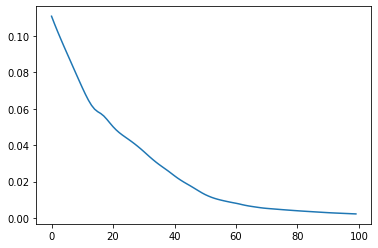

In [25]:
N = 64
C = 2
L = 64
H = 2

vae = VAE(C, H, hidden_channels=[3,4,5], up_down_sampling=[False, True], L_in=L, N=N)
# Optimizer for overfit tranning
optim = torch.optim.Adam(vae.parameters(), lr=1e-3)
train_overfit(vae, optim, max_iteration=100, sample_length=L)
# print(vae.muy)
# print(vae.log_var)

In [26]:
def train(model, opt, alpha=0.01, epochs=1, sample_length=32, batch_size=32):
  model.to(device)
  model.train()
  sample = torch.zeros((batch_size, 2, sample_length)).to(device=device, dtype=dtype)
  L = X_train.shape[2]
  loss_hist = []
  muy_hist = []
  min_loss = 1000
  for e in range(epochs):
    for iter in range(int(X_train.shape[2]/batch_size)):
      for i in range(batch_size):
        start = np.random.randint(0,L - sample_length)
        sample[i,:,:] = X_train[0,:,start:start + sample_length]
      x_hat, muy, log_var = model(sample)
      loss = loss_fn(sample, x_hat, muy, log_var, alpha)
      loss.backward()
      opt.step()
      opt.zero_grad()
      if loss.item() < min_loss:
        min_loss = loss.item()
      if loss_hist:
        loss_hist.append(loss.item()*0.1 + loss_hist[-1]*0.9)
      else:
        loss_hist.append(loss.item())
      # muy_hist.append(muy_hist[-1]*0.9 + muy)
    print('epoch: ', e, ' min loss = ', min_loss, 'evg loss ', loss_hist[-1])
    plt.plot(list(np.arange(len(loss_hist))), loss_hist)
    plt.show()

In [27]:
N = 64
C = 2
L = 32
H = 128

vae = VAE(C, 
          H, 
          hidden_channels=[4,8,16,32,64], 
          up_down_sampling=[False, True, False, False], 
          L_in=L, 
          N=N
      )


In [30]:
optim = torch.optim.Adam(vae.parameters(), lr=5e-4)

epoch:  0  min loss =  0.013264449313282967 evg loss  0.019423417651258146


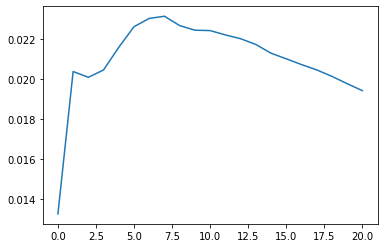

epoch:  1  min loss =  0.013248308561742306 evg loss  0.014923741665280028


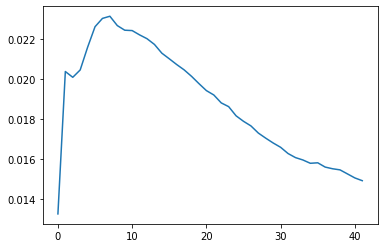

epoch:  2  min loss =  0.01255323551595211 evg loss  0.013872073623079056


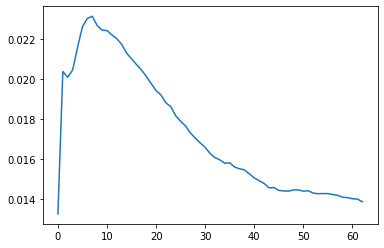

epoch:  3  min loss =  0.012097598984837532 evg loss  0.01311729415662366


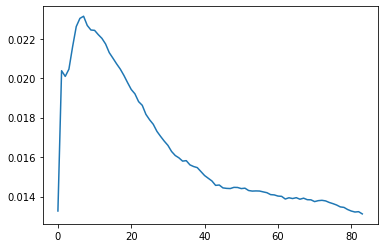

epoch:  4  min loss =  0.009228999726474285 evg loss  0.011018434240537226


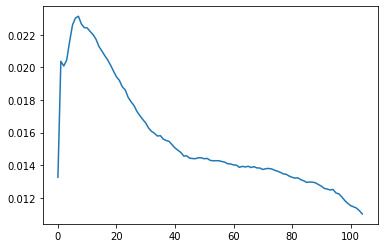

epoch:  5  min loss =  0.005564608611166477 evg loss  0.0073048743189419564


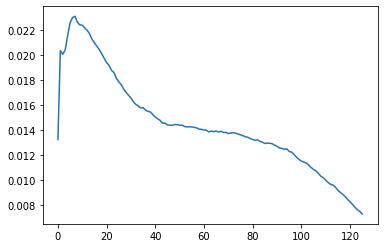

epoch:  6  min loss =  0.003497794736176729 evg loss  0.0045771026104706606


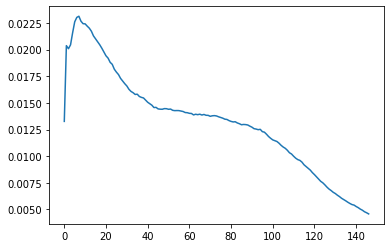

epoch:  7  min loss =  0.002863870933651924 evg loss  0.003371581585984158


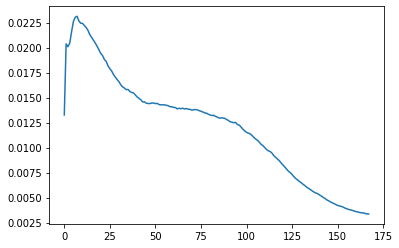

epoch:  8  min loss =  0.002569951117038727 evg loss  0.0028859866354014325


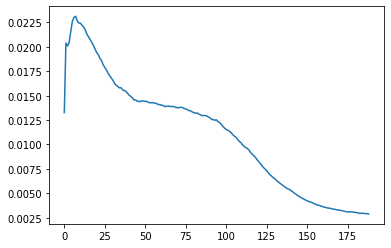

epoch:  9  min loss =  0.002329776296392083 evg loss  0.0025967428922945477


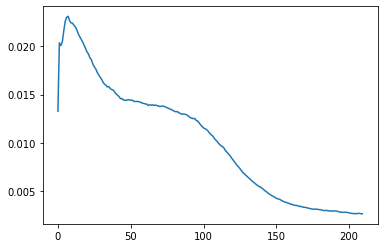

epoch:  10  min loss =  0.002072030445560813 evg loss  0.002514154048911637


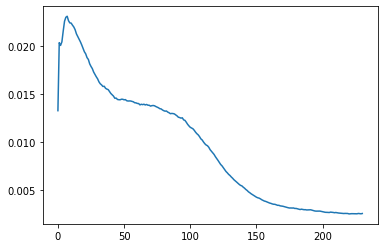

epoch:  11  min loss =  0.0020363365765661 evg loss  0.0023137169933889127


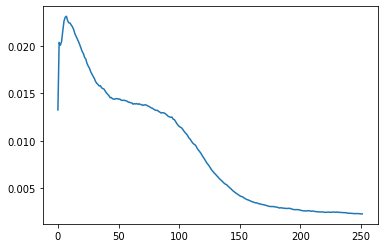

epoch:  12  min loss =  0.001857676776126027 evg loss  0.0023234420183438657


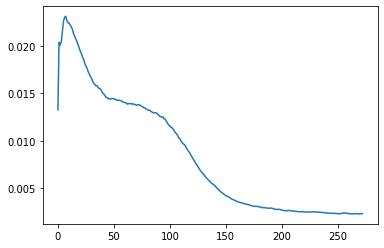

epoch:  13  min loss =  0.001857676776126027 evg loss  0.0023017021338197926


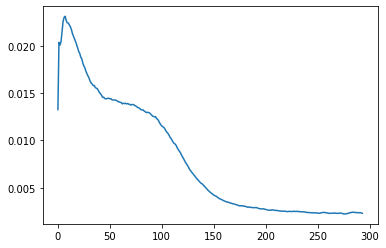

epoch:  14  min loss =  0.001857676776126027 evg loss  0.00237766599398371


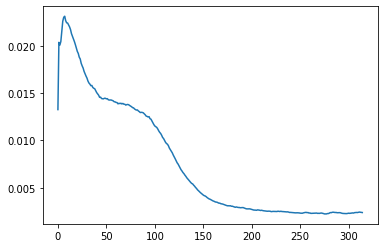

epoch:  15  min loss =  0.0018290318548679352 evg loss  0.002273499994071294


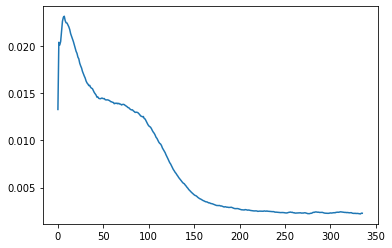

epoch:  16  min loss =  0.0018290318548679352 evg loss  0.0022295043486234684


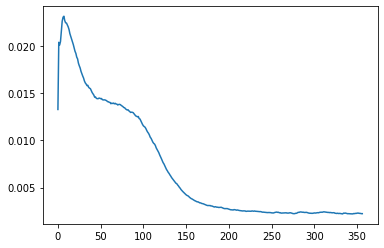

epoch:  17  min loss =  0.0018258215859532356 evg loss  0.0021830044202723452


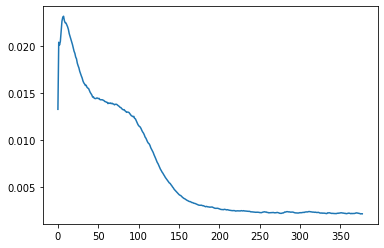

epoch:  18  min loss =  0.0016875293804332614 evg loss  0.002220446610825465


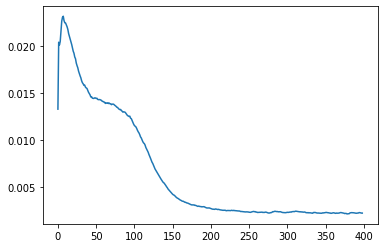

epoch:  19  min loss =  0.0016875293804332614 evg loss  0.002229382872699622


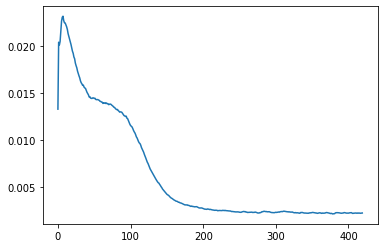

epoch:  20  min loss =  0.0016875293804332614 evg loss  0.0022641646134582997


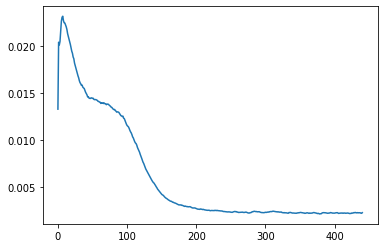

epoch:  21  min loss =  0.0016875293804332614 evg loss  0.002169683288386349


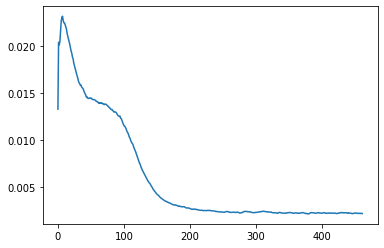

epoch:  22  min loss =  0.0016875293804332614 evg loss  0.0021704083979205


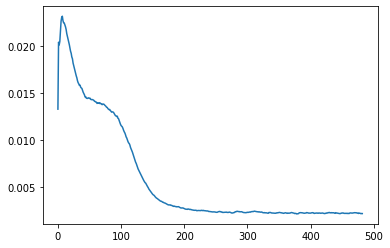

epoch:  23  min loss =  0.0016875293804332614 evg loss  0.0022209318444149943


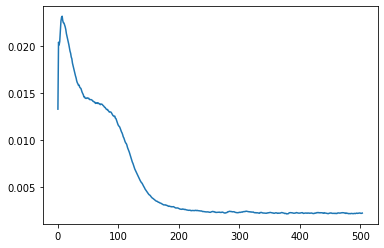

epoch:  24  min loss =  0.001655016327276826 evg loss  0.0020870197701479505


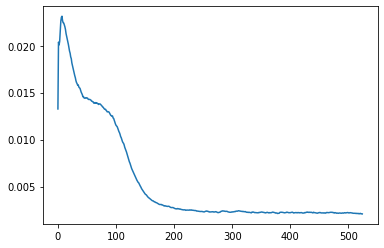

epoch:  25  min loss =  0.001655016327276826 evg loss  0.0020495476512451317


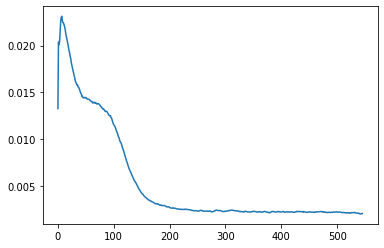

epoch:  26  min loss =  0.001655016327276826 evg loss  0.002049849537010746


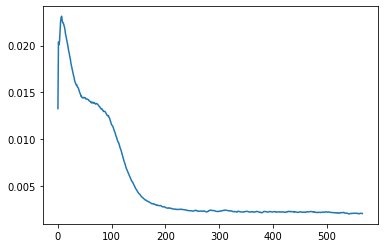

epoch:  27  min loss =  0.001655016327276826 evg loss  0.0020182588248703953


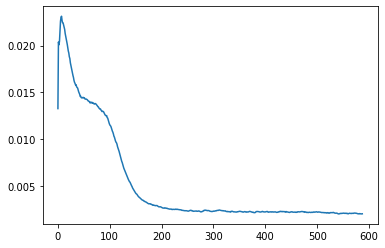

epoch:  28  min loss =  0.0015481030568480492 evg loss  0.0019288175277971395


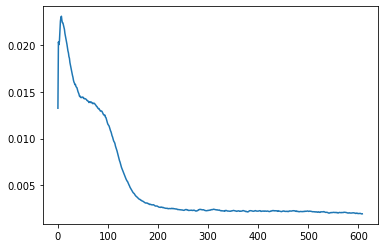

epoch:  29  min loss =  0.0015481030568480492 evg loss  0.0018875669081277397


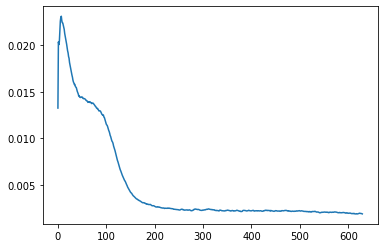

epoch:  30  min loss =  0.0015481030568480492 evg loss  0.001927912530659321


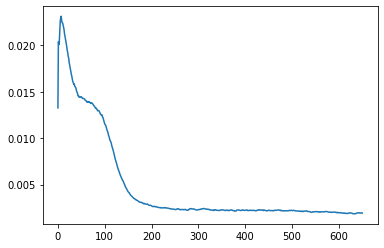

epoch:  31  min loss =  0.0015481030568480492 evg loss  0.0018471773486763326


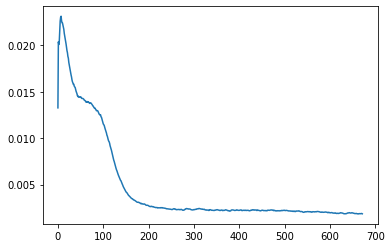

epoch:  32  min loss =  0.0014186466578394175 evg loss  0.0017403402505606425


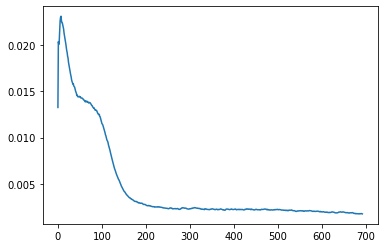

epoch:  33  min loss =  0.0013993177562952042 evg loss  0.001767615521478532


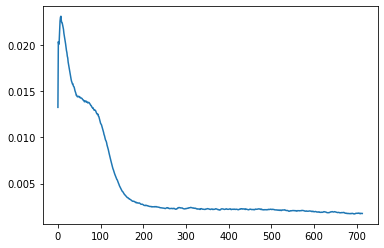

epoch:  34  min loss =  0.0013993177562952042 evg loss  0.0017442020197495057


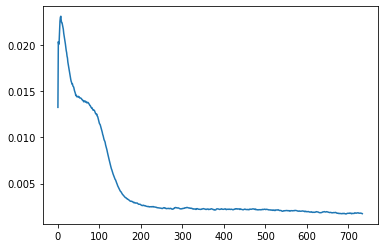

epoch:  35  min loss =  0.0013993177562952042 evg loss  0.0017267148290576726


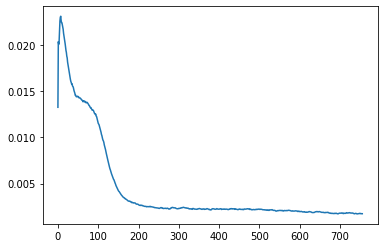

epoch:  36  min loss =  0.001324912765994668 evg loss  0.0017015581218153952


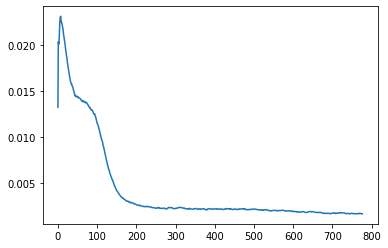

epoch:  37  min loss =  0.001324912765994668 evg loss  0.001737145661908399


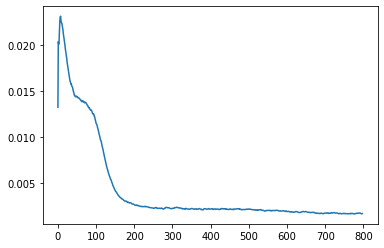

epoch:  38  min loss =  0.001324912765994668 evg loss  0.0017197160833934868


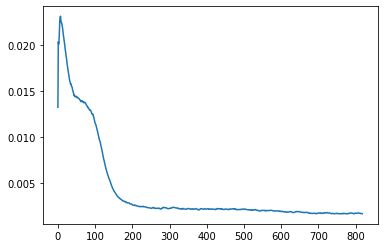

epoch:  39  min loss =  0.001324912765994668 evg loss  0.0016770328362720691


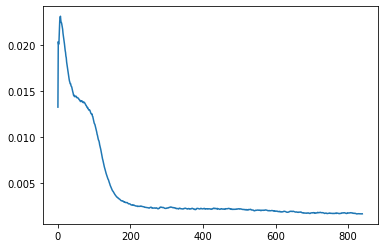

epoch:  40  min loss =  0.001324912765994668 evg loss  0.0017627844029443672


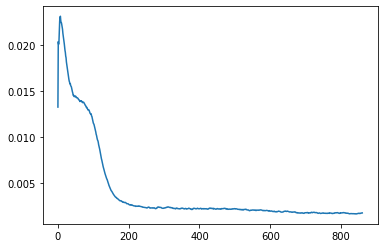

epoch:  41  min loss =  0.001324912765994668 evg loss  0.0017803514185466738


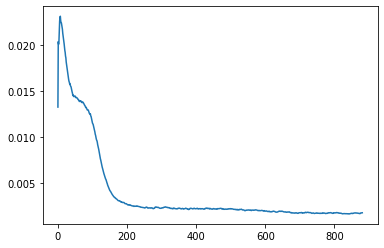

epoch:  42  min loss =  0.001324912765994668 evg loss  0.0017251654231074998


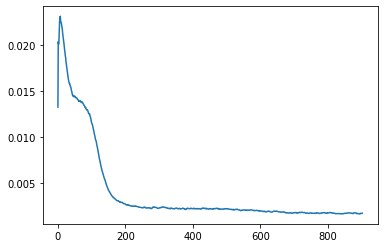

epoch:  43  min loss =  0.001324912765994668 evg loss  0.0017194600014980765


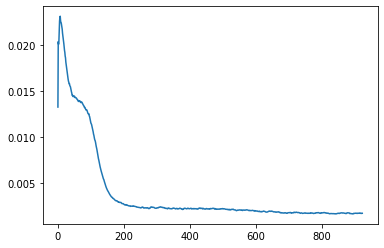

epoch:  44  min loss =  0.001324912765994668 evg loss  0.0017209735974617905


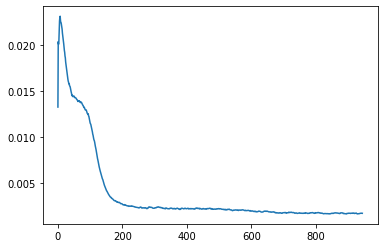

epoch:  45  min loss =  0.001324912765994668 evg loss  0.001701366876172649


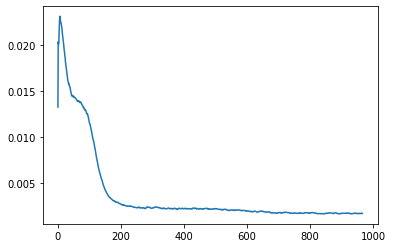

epoch:  46  min loss =  0.001324912765994668 evg loss  0.001741749945302944


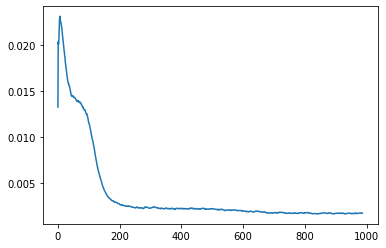

epoch:  47  min loss =  0.0012481262674555182 evg loss  0.001663300401300626


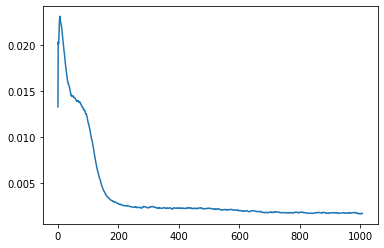

epoch:  48  min loss =  0.0012481262674555182 evg loss  0.00167139493644829


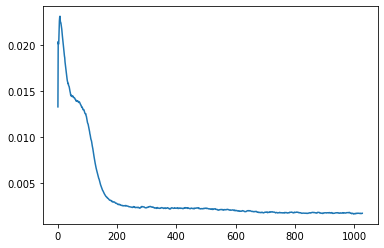

epoch:  49  min loss =  0.0012027730699628592 evg loss  0.0015990765411119674


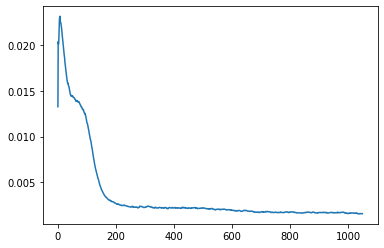

epoch:  50  min loss =  0.0012027730699628592 evg loss  0.0016901376458919389


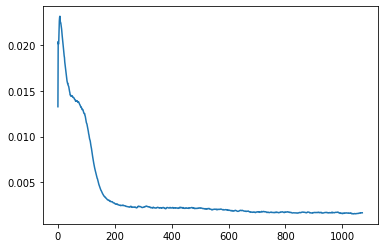

epoch:  51  min loss =  0.0012027730699628592 evg loss  0.0016345062849539899


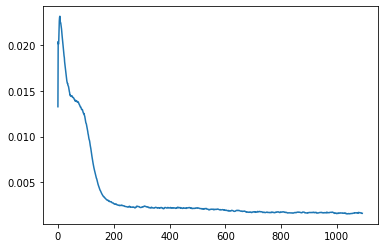

epoch:  52  min loss =  0.0012027730699628592 evg loss  0.0016439899759363697


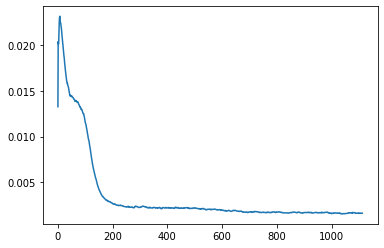

epoch:  53  min loss =  0.0012027730699628592 evg loss  0.0016408532137311012


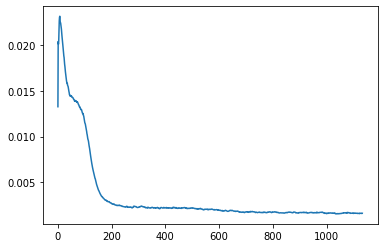

epoch:  54  min loss =  0.0012027730699628592 evg loss  0.0016326755147867734


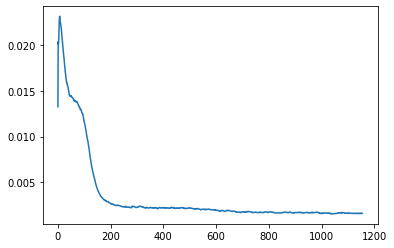

epoch:  55  min loss =  0.0012027730699628592 evg loss  0.0015619956265862565


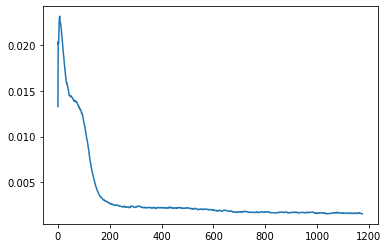

KeyboardInterrupt: ignored

In [31]:
train(vae, optim, epochs=100, alpha=0.01, batch_size=N, sample_length=L)

In [32]:
X_reconstruct = torch.zeros_like(X_test)
vae.to(device)
for i in range(int(X_test.shape[2]/L)-1):
  X_reconstruct[0,:,i*L:i*L+L], _, _ = vae(
      X_test[0,:,i*L:(i+1)*L].reshape(-1,2,L).to(device=device, dtype=dtype)
  )
print(X_reconstruct.shape)

torch.Size([1, 2, 223])


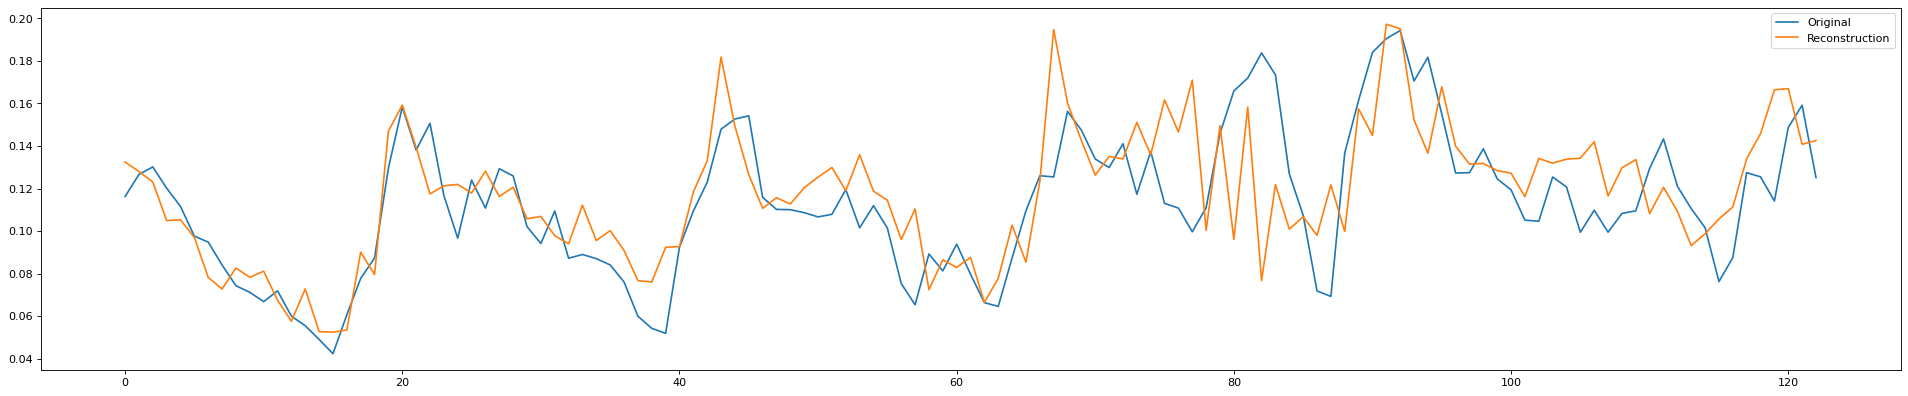

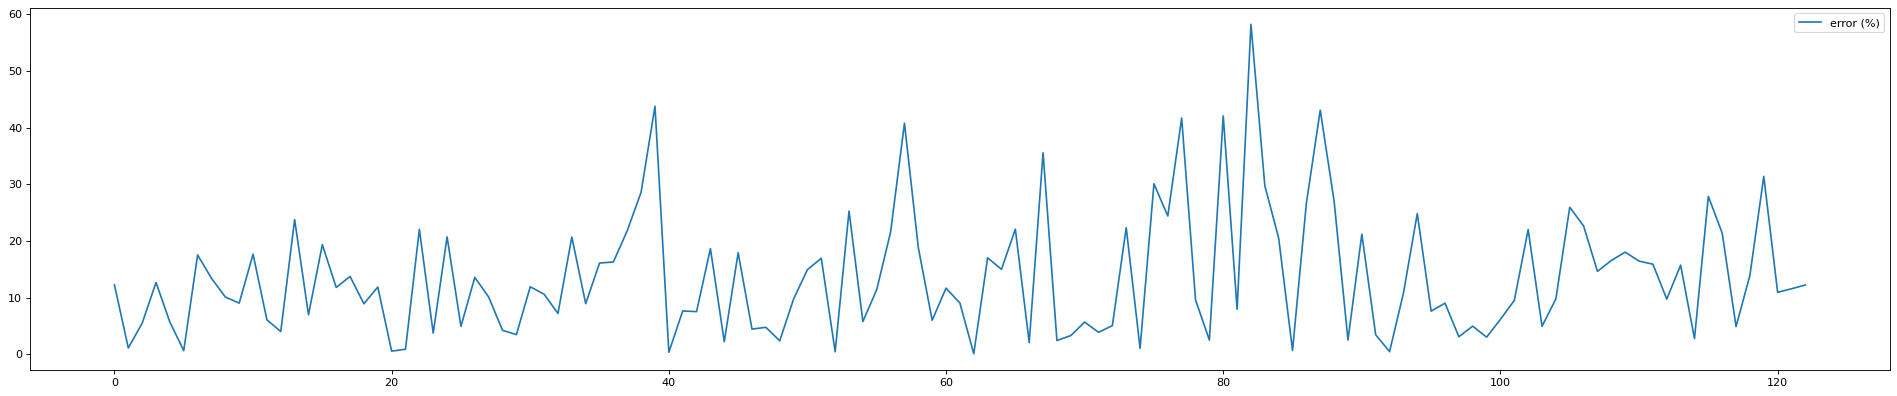

In [33]:
fig=plt.figure(figsize=(30,6), dpi=80)
plt.plot(np.arange(X_test.shape[2]-100), X_test[0,0,:-100].detach().numpy(), label='Original')
# plt.legend()
# plt.show()
# fig=plt.figure(figsize=(30,6), dpi=80)

plt.plot(np.arange(X_reconstruct.shape[2]-100), X_reconstruct[0,0,:-100].detach().numpy(), label='Reconstruction')
plt.legend()
plt.show()
fig=plt.figure(figsize=(30,6), dpi=80)
error = 100*torch.abs(X_reconstruct[0,0,:-100] - X_test[0,0,:-100])/torch.max(X_reconstruct[0,0,:-100], X_test[0,0,:-100])
plt.plot(np.arange(X_reconstruct.shape[2]-100), error.detach().numpy(), label='error (%)')
plt.legend()
plt.show()

torch.Size([1, 2, 1400])


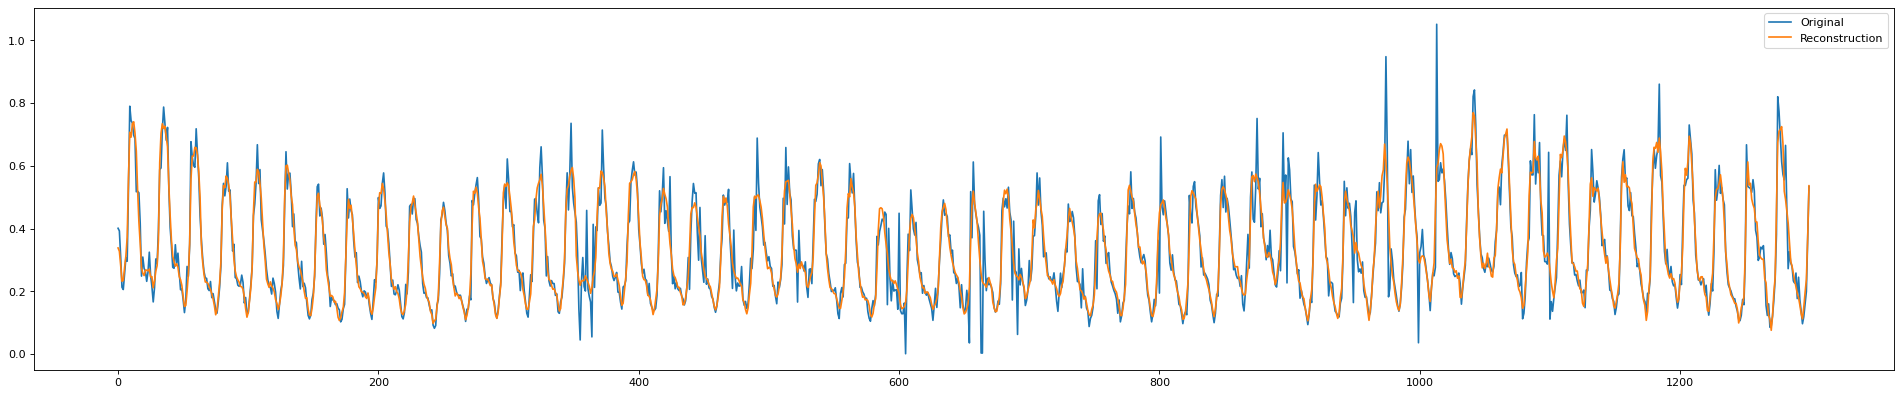

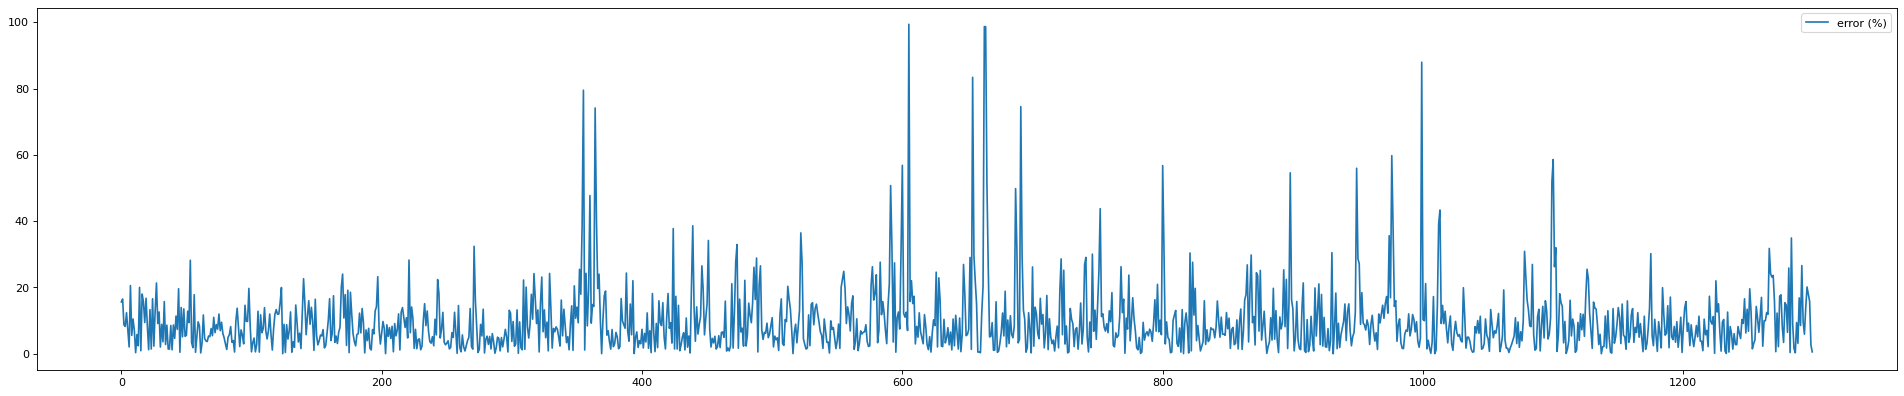

In [34]:
X_reconstruct = torch.zeros_like(X_train)
vae.to(device)
for i in range(int(X_train.shape[2]/L)-1):
  X_reconstruct[0,:,i*L:i*L+L], _, _ = vae(
      X_train[0,:,i*L:(i+1)*L].reshape(-1,2,L).to(device=device, dtype=dtype)
  )
print(X_reconstruct.shape)
fig=plt.figure(figsize=(30,6), dpi=80)
plt.plot(np.arange(X_train.shape[2]-100), X_train[0,1,:-100].detach().numpy(), label='Original')
# plt.legend()
# plt.show()
# fig=plt.figure(figsize=(30,6), dpi=80)

plt.plot(np.arange(X_reconstruct.shape[2]-100), X_reconstruct[0,1,:-100].detach().numpy(), label='Reconstruction')
plt.legend()
plt.show()
fig=plt.figure(figsize=(30,6), dpi=80)
error = 100*torch.abs(X_reconstruct[0,1,:-100] - X_train[0,1,:-100])/torch.max(X_reconstruct[0,1,:-100], X_train[0,1,:-100])
plt.plot(np.arange(X_reconstruct.shape[2]-100), error.detach().numpy(), label='error (%)')
plt.legend()
plt.show()